## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Load necessary modules

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle # to save calibration data
import os     # see if saved data exists
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## 1. I'll compute the camera calibration using chessboard images
### Here are the helper functions that does the calibration 

In [2]:
# We write this helper function to get the data ready for calibration
def prepare_calibration():
    nx=9
    ny=6
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)[0:720, 0:1280]

        print("{} shape:{}".format(fname.split('/')[-1], gray.shape))
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            
            #cv2.imshow('img',img)
            #cv2.waitKey(0)
        else:
            print("Failed to find corners in {}".format(fname))

    #cv2.destroyAllWindows()
    return objpoints, imgpoints, img

# This helper function does the calibration, and returns the
def calibrate_camera(objpoints, imgpoints, testImg):    
    retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, testImg.shape[0:2][::-1], None, None)
    return retval, cameraMatrix, distCoeffs

## 2. I'll calculate the perspective transformation matrices
### Here is the helper function that takes an image from the car's perspective, and calculate the perspective transformation matrix and the inverse matrix

In [3]:
# This function use hard coded image and points to get perspective transform
def perspective_transform(mtx, dist):
    img = cv2.imread('../test_images/straight_lines2.jpg')
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1], gray.shape[0])
    #print(img_size)

    # top left, top right, bottom right, bottom left
    # Hand picked points that form a rectangle in original image
    src = np.float32([[555, 476], 
                      [733, 476], 
                      [1035, 665], 
                      [286, 665]])

    dst = np.float32([[200, 10], 
                      [1080, 10], 
                      [1080, 710], 
                      [200, 710]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undist, M, img_size)

    return M, Minv

### The above 2 sections defines the functions that does the calibration and perspective transform, this section does the real calibration and perspective transform.

### It saves the calibration result and perspective transformation matrix into a pickle file, and load the file if it exists. So we don't need to run the calibration every time.

In [4]:
if not os.path.isfile('saved_params.p'):
    objpoints, imgpoints, testImg = prepare_calibration()
    retval, cameraMatrix, distCoeffs = calibrate_camera(objpoints, imgpoints, testImg)

    M, Minv = perspective_transform(cameraMatrix, distCoeffs)
    params={}
    params['cameraMatrix'] = cameraMatrix
    params['distCoeffs']   = distCoeffs
    params['M']            = M
    params['Minv']         = Minv
    with open('saved_params.p', 'wb') as f:
        pickle.dump(params, f, pickle.HIGHEST_PROTOCOL)

else:
    with open('saved_params.p', mode='rb') as f:
        print('params loaded')
        params = pickle.load(f)
        cameraMatrix, distCoeffs, M, Minv = params['cameraMatrix'], params['distCoeffs'], params['M'],params['Minv']

params loaded


### Let's show our calibration is working

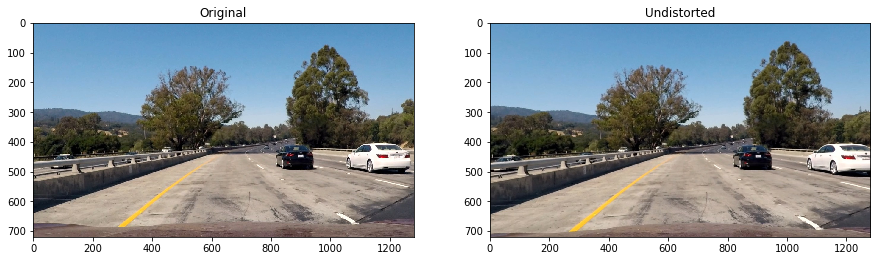

In [8]:
img_test_cali = plt.imread('../test_images/test1.jpg')
img_test_cali_undistorted = cv2.undistort(img_test_cali, cameraMatrix, distCoeffs, None, cameraMatrix)
plt.figure(figsize=(15,10))
plt.subplot(1,2,1); plt.imshow(img_test_cali); plt.title('Original')
plt.subplot(1,2,2); plt.imshow(img_test_cali_undistorted); plt.title('Undistorted')

### Let's show our perspective transformation is working

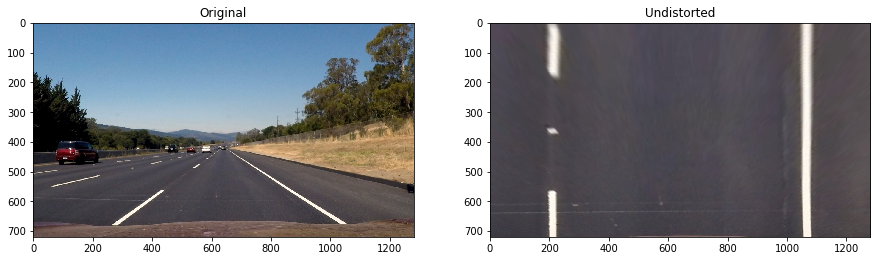

In [6]:
img_test_2 = plt.imread('../test_images/straight_lines2.jpg')
img_test_2_undist = cv2.undistort(img_test_2, cameraMatrix, distCoeffs, None, cameraMatrix)
img_test_2_warped = cv2.warpPerspective(img_test_2_undist, M, (img_test_2_undist.shape[1], img_test_2_undist.shape[0]))
plt.figure(figsize=(15,5))
plt.subplot(1,2,1); plt.imshow(img_test_2); plt.title('Original')
plt.subplot(1,2,2); plt.imshow(img_test_2_warped); plt.title('Undistorted')

## 3. Color and gradient thresholding
### Define some functions that dose the processing

In [40]:
def apply_threshold(gray, thresh):
    """
    Given a grayscale image and a threshold = (thresh_min, thresh_max)
    output a binary image between the threshold
    """

    binary_out = np.zeros_like(gray)
    binary_out[(gray >= thresh[0]) & (gray <= thresh[1])] = 1
    
    return binary_out

def abs_sobel_thresh(img, orient='x', thresh=(0,255)):
    """ Threshold gradient on given orientation """
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img.copy()

    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    
    normalized_gray = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return apply_threshold(normalized_gray, thresh)

# Combine color and gradient threshold
def color_and_gradient_thresholding0(img, s_thresh=(170, 255), sx_thresh=(20, 100), plot_result=False):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    
    # Do sobel_x and threshold
    binary_sobelx = abs_sobel_thresh(s_channel, thresh=sx_thresh)
    
    # threshold the s channel
    binary_s_channel = apply_threshold(s_channel, thresh=s_thresh)
    
    combined_binary = np.zeros_like(s_channel)
    combined_binary[(binary_sobelx == 1) | (binary_s_channel == 1)] = 1
    
    if plot_result == True:
        color_binary = np.dstack((binary_sobelx,  np.zeros_like(binary_sobelx), binary_s_channel))
        plt.figure(figsize=(15,10))
        plt.subplot(1,2,1); plt.imshow(color_binary); plt.title('stacked threshold')
        plt.subplot(1,2,2); plt.imshow(combined_binary, cmap='gray'); plt.title('combined')
        
    return combined_binary

def color_and_gradient_thresholding(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.float)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    combined_binary = np.zeros_like(s_channel)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    # ax1.set_title('Stacked thresholds')
    # ax1.imshow(color_binary)

    # ax2.set_title('Combined S channel and gradient thresholds')
    # ax2.imshow(combined_binary, cmap='gray')

    return combined_binary

### Test the result of the color and gradient thresholding

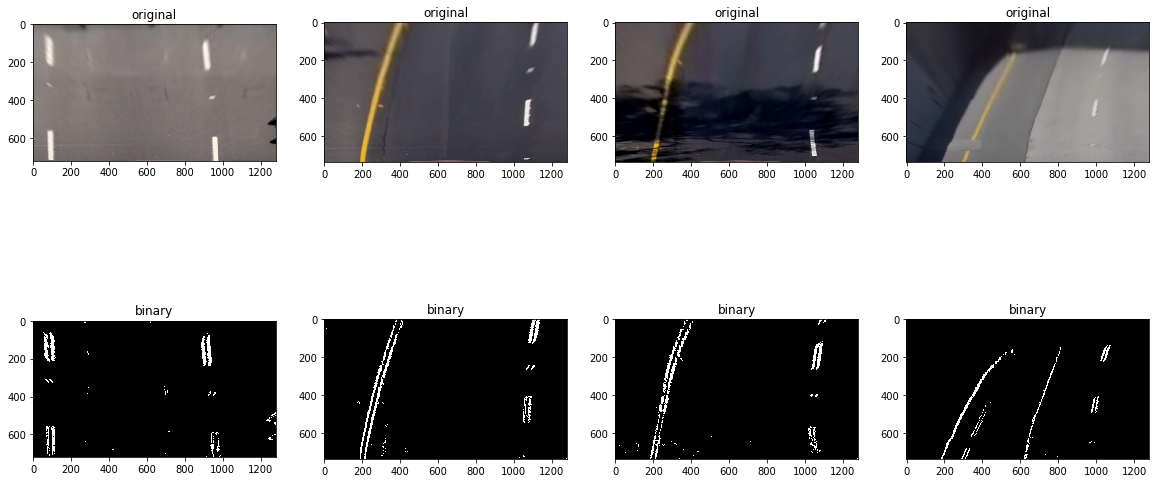

In [41]:
all_test_imgs = glob.glob('../test_images/*.png')
warped_img_list = []
threshold_img_list = []
for f_img in all_test_imgs:
    test_img = plt.imread(f_img)
    test_img_undist = cv2.undistort(test_img, cameraMatrix, distCoeffs, None, cameraMatrix)
    test_img_warped = cv2.warpPerspective(test_img_undist, M, (test_img_undist.shape[1], test_img_undist.shape[0]))
    test_img_thresholding = color_and_gradient_thresholding(test_img_warped)
    
    warped_img_list.append(test_img_warped)
    threshold_img_list.append(test_img_thresholding)

n=len(warped_img_list)
plt.figure(figsize=(20,10))
for i in range(n):
    plt.subplot(2,n,i+1);   plt.imshow(warped_img_list[i]); plt.title('original')
    plt.subplot(2,n,i+1+n); plt.imshow(threshold_img_list[i], cmap='gray'); plt.title('binary')

## 4. Detect the lane pixels and fit them with polynomials

### Function that search lanes using sliding window

In [42]:
def find_lane_sliding_window(binary_warped, plot_result=False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/3):,:], axis=0)
    # plt.figure()
    # plt.plot(np.array(range(0,binary_warped.shape[1])), histogram)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = out_img.astype(np.uint8)    

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 60
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Check if overall we find enough good points
    if len(left_lane_inds) > minpix * nwindows/2 and len(right_lane_inds) > minpix * nwindows/2:
        good_detection = True
    else:
        good_detection = False

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    
    # Visualization
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    if plot_result == True:
        plt.figure()
        plt.imshow(out_img)

        plt.figure()
        plt.imshow(binary_warped)
        plt.plot(left_fitx, ploty, color='red')
        plt.plot(right_fitx, ploty, color='red')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

    return left_fit, right_fit, ploty, good_detection, left_fitx, right_fitx

### Assume you have a good detection previously, this function search lanes in a window around your previously detected lanes

In [43]:
def find_lanes_without_window(binary_warped, left_fit, right_fit, visualize=False):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Check if overall we find enough good points
    if len(left_lane_inds) > 50*9/2 and len(right_lane_inds) > 50*9/2:
        good_detection = True
    else:
        good_detection = False
        print('find_lanes_without_window, failed')
        
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    if visualize:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    return left_fit, right_fit, ploty, good_detection, left_fitx, right_fitx

### Now test if lane finding in sliding window works by running it on all test images. The test images includes snap shots from the project\_video.mp4 and challenge\_video.mp4

True
True
True
True
True
True
True
True
True
True
True
True


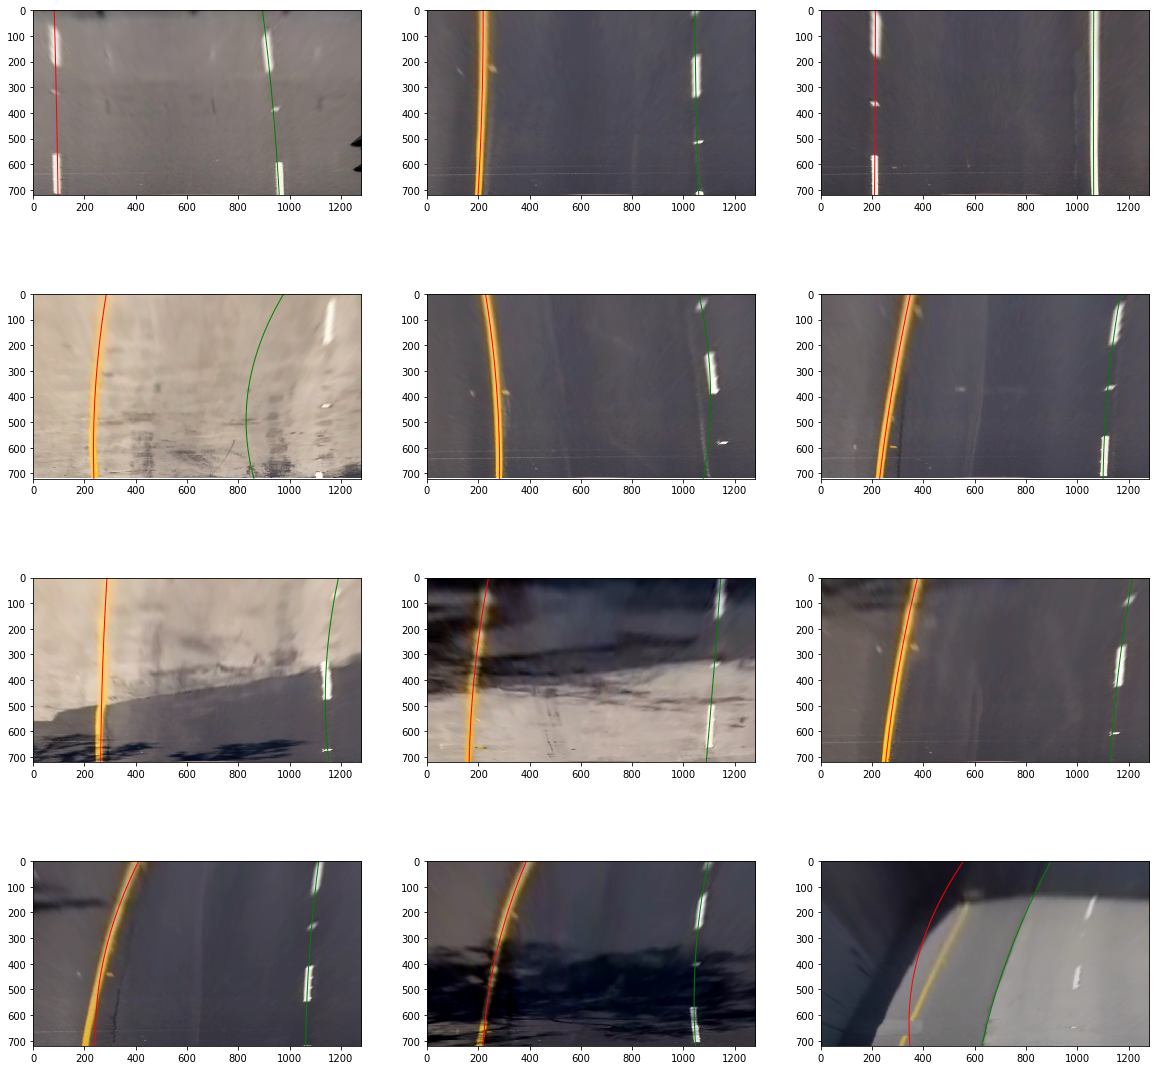

In [44]:
all_test_imgs = glob.glob('../test_images/*')
warped_img_list = []
threshold_img_list = []
left_fitx_list = []
right_fitx_list= []
ploty_list = []
for f_img in all_test_imgs:
    test_img = plt.imread(f_img)
    test_img_undist = cv2.undistort(test_img, cameraMatrix, distCoeffs, None, cameraMatrix)
    test_img_warped = cv2.warpPerspective(test_img_undist, M, (test_img_undist.shape[1], test_img_undist.shape[0]))
    test_img_thresholding = color_and_gradient_thresholding(test_img_warped)
    
    left_fit, right_fit, ploty, good_detection, left_fitx, right_fitx = find_lane_sliding_window(test_img_thresholding)
    print(good_detection)
    warped_img_list.append(test_img_warped)
    left_fitx_list.append(left_fitx)
    right_fitx_list.append(right_fitx)
    ploty_list.append(ploty)
    


n=len(warped_img_list)
nrow = int(np.ceil(n/3))
plt.figure(figsize=(20,20))
for i in range(n):
    plt.subplot(nrow,3,i+1);   plt.imshow(warped_img_list[i]); 
    plt.plot(left_fitx_list[i], ploty_list[i], color='red', linewidth=1);
    plt.plot(right_fitx_list[i],ploty_list[i], color='green', linewidth=1);
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    #plt.subplot(2,n,i+1+n); plt.imshow(threshold_img_list[i]);

In [36]:
def draw_result_in_car_view(undist, warped, left_fitx, right_fitx, ploty, Minv, plot_result=False):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    if plot_result == True:
        plt.figure()
        plt.imshow(result)

    return result

## Note: The meter per pixel on each direction depends on the perspective transform we use.
def measure_curvature(left_fit, right_fit, ploty, left_fitx, right_fitx):   
    # straight_line2.jpg
    x_meter_per_pixel = 3.7/(1064-210) # 3.7 meters (distance between lane) per 854 pixels in x dimension
    y_meter_per_pixel = 3.0/170 #(566-180)  # 3 meters (the gap in dashed line) takes 386 pixels in y direction

    left_fit_meter = np.polyfit(ploty*y_meter_per_pixel, left_fitx*x_meter_per_pixel, 2)
    right_fit_meter = np.polyfit(ploty*y_meter_per_pixel, right_fitx*x_meter_per_pixel, 2)
    
    y_eval = np.max(ploty)*y_meter_per_pixel
    
    left_R = ((1 + (2*left_fit_meter[0]*y_eval + left_fit_meter[1])**2)**1.5) / np.absolute(2*left_fit_meter[0])
    right_R = ((1 + (2*right_fit_meter[0]*y_eval + right_fit_meter[1])**2)**1.5) / np.absolute(2*right_fit_meter[0])
    
    return np.mean([left_R, right_R])

def find_distance(leftx, rightx):
    den_left = M[2,0] * leftx + M[2,1] * 719 + M[2,2]
    num_left = M[0,0] * leftx + M[0,1] * 719 + M[0,2]
    
    den_right = M[2,0] * rightx + M[2,1] * 719 + M[2,2]
    num_right = M[0,0] * rightx + M[0,1] * 719 + M[0,2]

    return (num_right/den_right - num_left/den_left)/2 - 1280/2 

#TODO
def add_text(img, curvature, distance_from_center, fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, color=(255, 255, 255), lineType=cv2.LINE_AA, thickness=3):
    img_copy = img.copy()
    text1 = 'Radius of curvature = {0:.1f}(m)'.format(curvature)
    text2 = 'Vehile is {0:.2f}m from center'.format(distance_from_center) 
    cv2.putText(img_copy, text1, (50, 100), fontFace=fontFace, fontScale=fontScale, color=color, lineType=lineType, thickness=thickness)
    cv2.putText(img_copy, text2, (50, 180), fontFace=fontFace, fontScale=fontScale, color=color, lineType=lineType, thickness=thickness)
    
    return img_copy

## Finally, our pipeline

In [37]:
def my_pipeline(testImg):
    global left_fit
    global right_fit
    global good_fit

    undist = cv2.undistort(testImg, cameraMatrix, distCoeffs, None, cameraMatrix)
    warped = cv2.warpPerspective(undist, M, (undist.shape[1], undist.shape[0]))

    binary_img = color_and_gradient_thresholding(warped)

    if good_fit == None or good_fit == False:
        print('failed to detect lane')
        left_fit, right_fit, ploty, good_fit, left_fitx, right_fitx = find_lane_sliding_window(binary_img)
    else:
        left_fit, right_fit, ploty, good_fit, left_fitx, right_fitx = find_lanes_without_window(binary_img, left_fit, right_fit)

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    result = draw_result_in_car_view(undist, binary_img, left_fitx, right_fitx, ploty, Minv)
    
    curvature_R = measure_curvature(left_fit, right_fit, ploty, left_fitx, right_fitx)   
    
    x_meter_per_pixel = 3/(1064-210)
    distance_from_center = find_distance(int(left_fitx[-1]), int(right_fitx[-1]))*x_meter_per_pixel
    
    result = add_text(result, curvature_R, distance_from_center)
    return result

### Test on image

failed to detect lane


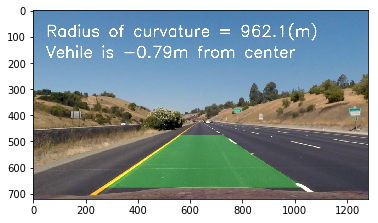

In [38]:
good_fit = None
left_fit=None
right_fit=None

testImg = plt.imread('../test_images/straight_lines1.jpg')

undist = cv2.undistort(testImg, cameraMatrix, distCoeffs, None, cameraMatrix)
warped = cv2.warpPerspective(undist, M, (undist.shape[1], undist.shape[0]))

binary_img = color_and_gradient_thresholding(warped)

after_pipeline = my_pipeline(testImg)
plt.figure()
plt.imshow(after_pipeline)


In [39]:

good_fit = None
left_fit=None
right_fit=None


white_output = 'output_project_video_test6.mp4'
clip1 = VideoFileClip("../project_video.mp4")
clip_processed = clip1.fl_image(my_pipeline) #NOTE: this function expects color images!!
clip_processed.write_videofile(white_output, audio=False)


failed to detect lane
[MoviePy] >>>> Building video output_project_video_test6.mp4
[MoviePy] Writing video output_project_video_test6.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:41<00:00,  7.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video_test6.mp4 

